- Group Normalization (8)


**Caveats**

Credit: Zongyi Li
Based on FNO paper's implementation, I am testing my proposed model.


# Implementation


In [1]:
import matplotlib.pyplot as plt

import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import os
import operator
from functools import reduce

#################################################
#
# Utilities
#
#################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size() + (2,) if p.is_complex() else p.size()))
    return c


class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h ** (self.d / self.p)) * torch.norm(
            x.view(num_examples, -1) - y.view(num_examples, -1), self.p, 1
        )

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(
            x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1
        )
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)

        return diff_norms / y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [2]:
import torch.nn.functional as F
from timeit import default_timer

torch.manual_seed(0)
np.random.seed(0)


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes1] = self.compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)
        self.norm = nn.GroupNorm(8, mid_channels)

    def forward(self, x):
        x = self.mlp1(x)
        x = self.norm(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 8  # pad the domain if input is non-periodic
        self.fdepth = 4  # number of fourier blocks

        self.p = nn.Linear(2, self.width)  # input channel_dim is 2: (u0(x), x)
        self.convs = nn.ModuleList(
            [
                SpectralConv1d(self.width, self.width, self.modes1)
                for _ in range(self.fdepth)
            ]
        )
        self.mlps = nn.ModuleList(
            [MLP(self.width, self.width, self.width) for _ in range(self.fdepth)]
        )
        self.ws = nn.ModuleList(
            [nn.Conv1d(self.width, self.width, 1) for _ in range(self.fdepth)]
        )
        self.norms = nn.ModuleList(
            [nn.GroupNorm(8, self.width) for _ in range(self.fdepth)]
        )
        self.q = MLP(self.width, 1, self.width * 2)  # output channel_dim is 1: u1(x)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        for i in range(self.fdepth):
            x1 = self.convs[i](x)
            x1 = self.mlps[i](x1)
            x2 = self.ws[i](x)
            x2 = self.norms[i](x2)
            x = x1 + x2
            if i != self.fdepth - 1:
                x = F.gelu(x)

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [3]:
################################################################
#  configurations
################################################################
NTRAIN = 1000
NTEST = 100

SUB = 2**3  # subsampling rate
H = 2**13 // SUB  # total grid size divided by the subsampling rate
S = H

BATCH_SIZE = 20
LEARNING_RATE = 0.001
EPOCHS = 500
ITERATIONS = EPOCHS * (NTRAIN // BATCH_SIZE)

MODES = 16
WIDTH = 64

PAR_PATH = "/kaggle/input/" if "kaggle" in os.getcwd() else "./"
PATH = PAR_PATH + "burgers/burgers_data_R10.mat"

In [4]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader(PATH)
x_data = dataloader.read_field("a")[:, ::SUB]
y_data = dataloader.read_field("u")[:, ::SUB]

x_train = x_data[:NTRAIN, :]
y_train = y_data[:NTRAIN, :]
x_val = x_data[-NTEST:, :]
y_val = y_data[-NTEST:, :]

x_train = x_train.reshape(NTRAIN, S, 1)
x_val = x_val.reshape(NTEST, S, 1)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE, shuffle=False
)

# model
model = FNO1d(MODES, WIDTH).to(device)
print(count_params(model))

584129


In [5]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ITERATIONS)
myloss = LpLoss(size_average=False)

train_mse_history = []
train_l2_history = []
test_l2_history = []

for ep in range(EPOCHS):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(
            out.view(BATCH_SIZE, -1), y.view(BATCH_SIZE, -1), reduction="mean"
        )
        l2 = myloss(out.view(BATCH_SIZE, -1), y.view(BATCH_SIZE, -1))
        l2.backward()  # use the l2 relative loss

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    # Compute training errors
    train_mse /= len(train_loader)
    train_l2 /= NTRAIN

    # Validation
    model.eval()
    val_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

            out = model(x)
            val_l2 += myloss(out.view(BATCH_SIZE, -1), y.view(BATCH_SIZE, -1)).item()

    val_l2 /= NTEST

    train_mse_history.append(train_mse)
    train_l2_history.append(train_l2)
    test_l2_history.append(val_l2)

    t2 = default_timer()
    print(ep, t2 - t1, train_mse, train_l2, val_l2)

torch.save(model.state_dict(), "model_burgers_weights.pth")
np.savez(
    "burgers_train_history.npz", train_mse_history, train_l2_history, test_l2_history
)

0 2.3698685549999823 0.026389757845317944 0.24038387954235077 0.08684799790382386
1 0.6078340470000114 0.002332347056362778 0.10439632439613342 0.08580471992492676
2 0.6130614679999837 0.0021460095030488447 0.0948544076681137 0.0467780339717865
3 0.6093477569999948 0.0008249240412260406 0.06209001713991165 0.0471316123008728
4 0.6007649129999777 0.0009562402847222984 0.06933807194232941 0.08308275103569031
5 0.6032045589999768 0.000675707867485471 0.05318513959646225 0.05307331085205078
6 0.5984863509999911 0.0005329057748895139 0.04925934648513794 0.07262127995491027
7 0.6085447270000088 0.0009407931356690824 0.06897945994138718 0.06358532309532165
8 0.608376112000002 0.0004690954310353845 0.04610980513691902 0.0437608253955841
9 0.6087838689999785 0.0004544988670386374 0.04786548081040382 0.028419501781463623
10 0.6043746900000144 0.0003819809292326681 0.03853294935822487 0.020109845101833345
11 0.6038783320000221 0.00040164632897358386 0.04044558969140053 0.03588355720043182
12 0.63

# Train vs. Validation Loss


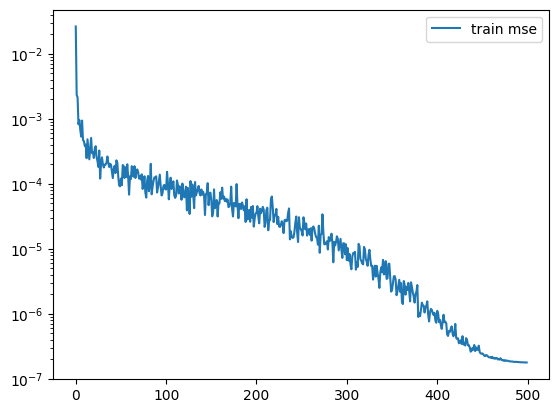

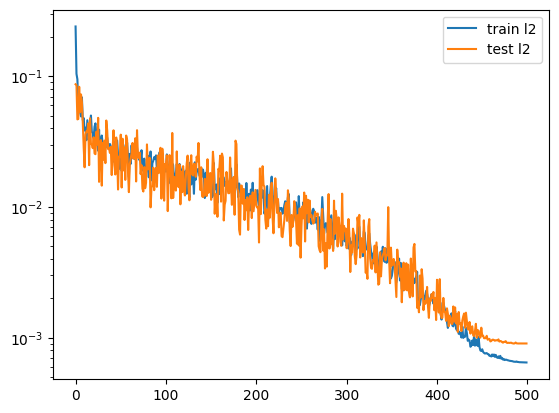

In [6]:
plt.figure()
plt.semilogy(train_mse_history, label="train mse")
plt.legend()

plt.figure()
plt.semilogy(train_l2_history, label="train l2")
plt.semilogy(test_l2_history, label="test l2")
plt.legend()
plt.show()

# Test


In [7]:
model = FNO1d(MODES, WIDTH).to(device)
model.load_state_dict(torch.load("model_burgers_weights.pth", map_location=device))
model.eval()

FNO1d(
  (p): Linear(in_features=2, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x SpectralConv1d()
  )
  (mlps): ModuleList(
    (0-3): 4 x MLP(
      (mlp1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (mlp2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (ws): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (norms): ModuleList(
    (0-3): 4 x GroupNorm(8, 64, eps=1e-05, affine=True)
  )
  (q): MLP(
    (mlp1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (mlp2): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
    (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
  )
)

In [8]:
dataloader = MatReader(PATH)
x_data = dataloader.read_field("a")[:, ::SUB]
y_data = dataloader.read_field("u")[:, ::SUB]

x_val = x_data[-NTEST:, :].reshape(NTEST, S, 1)
y_val = y_data[-NTEST:, :]

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_val, y_val), batch_size=1, shuffle=False
)

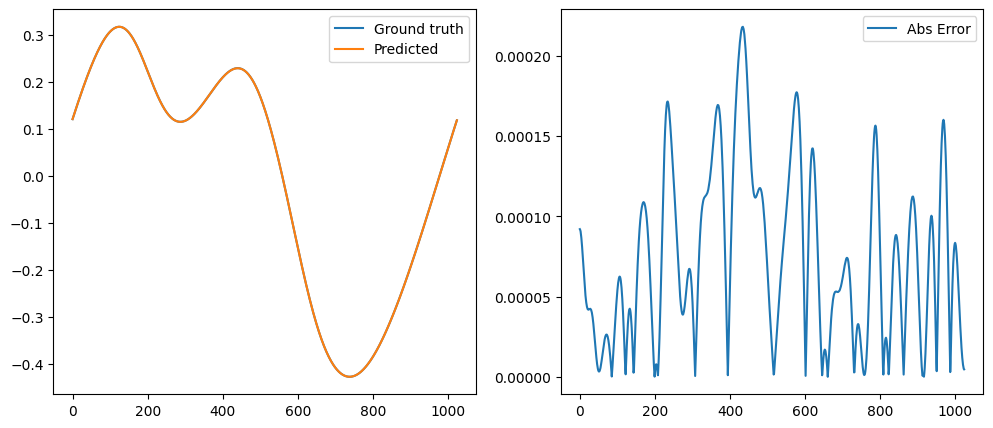

In [9]:
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        out = model(x)

        y = y[0].cpu().numpy()
        out = out[0, :, 0].cpu().numpy()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(y, label="Ground truth")
        plt.plot(out, label="Predicted")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.abs(y - out), label="Abs Error")
        plt.legend()
        plt.show()

        break

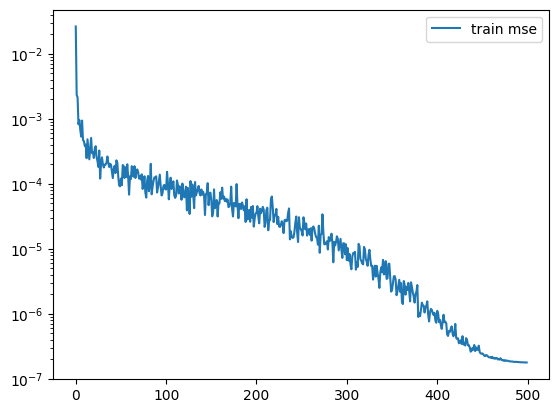

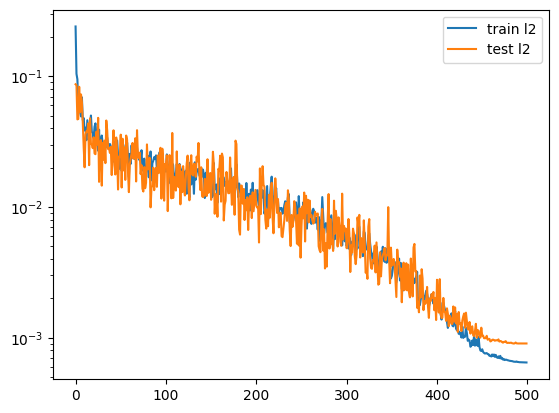

In [10]:
losses = np.load("burgers_train_history.npz")
train_mse_history, train_l2_history, test_l2_history = (
    losses["arr_0"],
    losses["arr_1"],
    losses["arr_2"],
)

plt.figure()
plt.semilogy(train_mse_history, label="train mse")
plt.legend()

plt.figure()
plt.semilogy(train_l2_history, label="train l2")
plt.semilogy(test_l2_history, label="test l2")
plt.legend()
plt.show()